In [92]:
# Import ros package:
import rospy
from geometry_msgs.msg import Twist
from nav_msgs.msg import Odometry

In [93]:
# Import do_mpc package:
import do_mpc
from casadi import *

import math
import numpy as np

In [94]:
# do-mpc implementation
model_type = 'continuous' # either 'discrete' or 'continuous'
model = do_mpc.model.Model(model_type)

x = model.set_variable(var_type='_x', var_name='x', shape=(1,1))
y = model.set_variable(var_type='_x', var_name='y', shape=(1,1))
theta = model.set_variable(var_type='_x', var_name='theta', shape=(1,1))

v = model.set_variable(var_type='_u', var_name='v')
w = model.set_variable(var_type='_u', var_name='w')
    
model.set_rhs('x', v*np.cos(theta))
model.set_rhs('y', v*np.sin(theta))
model.set_rhs('theta', w)
model.setup()

In [95]:
mpc = do_mpc.controller.MPC(model)

setup_mpc = {
    'n_horizon': 20,
    't_step': 0.1,
    'n_robust': 1,
    'store_full_solution': True,
}
mpc.set_param(**setup_mpc)

mterm = (x-2)**2 + (y-2)**2 + (theta)**2
lterm = (x-2)**2 + (y-2)**2 + (theta)**2
    
mpc.set_objective(mterm=mterm, lterm=lterm)

In [96]:
# Lower bounds on states:
mpc.bounds['lower','_x', 'x'] = 0
mpc.bounds['lower','_x', 'y'] = 0

# Lower bounds on inputs:
mpc.bounds['lower','_u', 'v'] = -1
mpc.bounds['lower','_u', 'w'] = -1

# Lower bounds on inputs:
mpc.bounds['upper','_u', 'v'] = 1
mpc.bounds['upper','_u', 'w'] = 1

mpc.setup()

In [97]:
simulator = do_mpc.simulator.Simulator(model)
simulator.set_param(t_step = 0.1)
simulator.setup()
x0 = np.array([0, 0, 0]).reshape(-1, 1)
print(x0)
simulator.x0 = x0
mpc.x0 = x0
mpc.set_initial_guess()

[[0]
 [0]
 [0]]


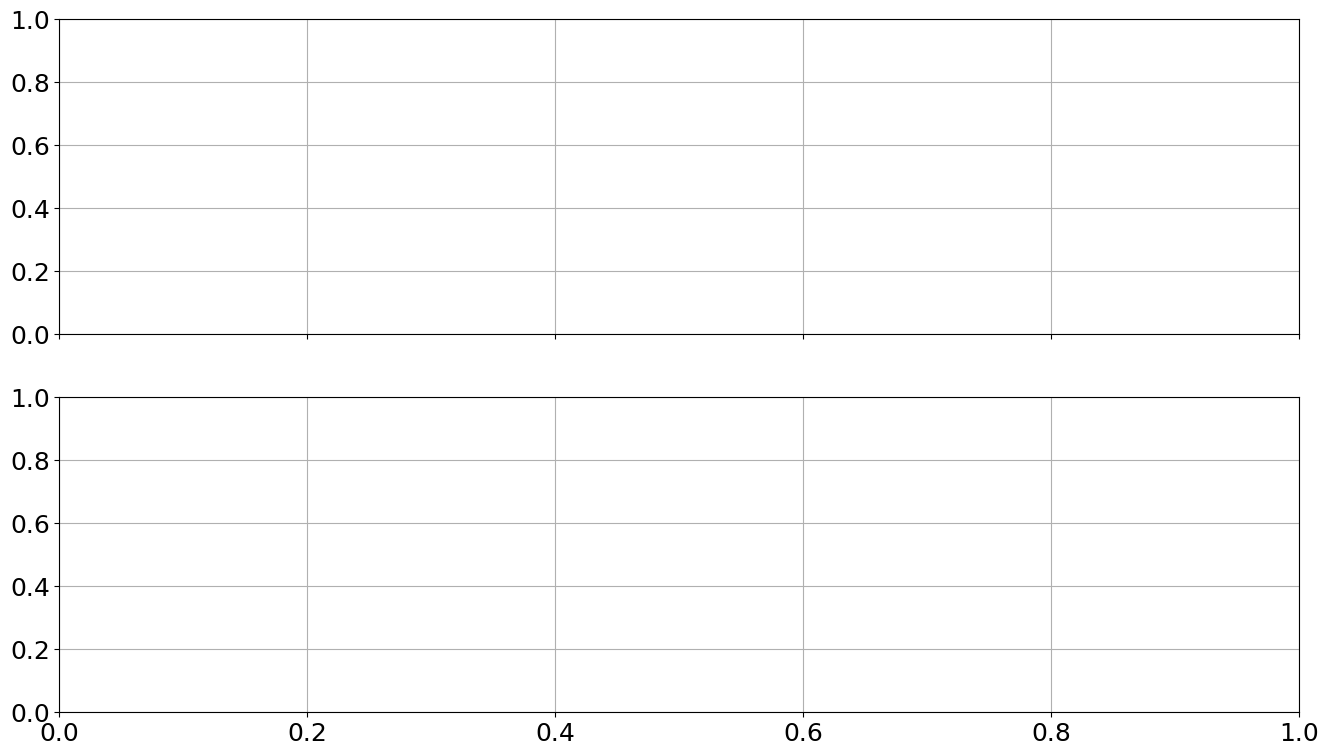

In [98]:
import matplotlib.pyplot as plt
import matplotlib as mpl

# Customizing Matplotlib:
mpl.rcParams['font.size'] = 18
mpl.rcParams['lines.linewidth'] = 3
mpl.rcParams['axes.grid'] = True

mpc_graphics = do_mpc.graphics.Graphics(mpc.data)
sim_graphics = do_mpc.graphics.Graphics(simulator.data)

# We just want to create the plot and not show it right now. This "inline magic" supresses the output.
fig, ax = plt.subplots(2, sharex=True, figsize=(16,9))
fig.align_ylabels()

In [99]:
%%capture
for g in [sim_graphics, mpc_graphics]:
    g.add_line(var_type='_x', var_name='x', axis=ax[0])
    g.add_line(var_type='_x', var_name='y', axis=ax[0])
    g.add_line(var_type='_x', var_name='theta', axis=ax[0])

    g.add_line(var_type='_u', var_name='v', axis=ax[1])
    g.add_line(var_type='_u', var_name='w', axis=ax[1])
    

ax[0].set_ylabel('Position [m]')
ax[1].set_ylabel('Input motor')
ax[1].set_xlabel('time [s]')

In [105]:
pos_x = 0
pos_y = 0
ang_z = 0

def get_pose(msg):
    pos_x = msg.pose.pose.position.x
    pos_y = msg.pose.pose.position.y
    ang_z = msg.pose.pose.orientation.z

    print("pos_x")


In [109]:
rospy.init_node('husky', anonymous=True)
pub = rospy.Publisher('/husky_velocity_controller/cmd_vel', Twist, queue_size=1)
rospy.Subscriber('/husky_velocity_controller/odom', Odometry, get_pose)

rospy.spin()

move_cmd = Twist()
rate = rospy.Rate(10)

In [110]:
u0 = np.array([0, 0]).reshape(2,1)


for i in range(100):

    states = np.array([pos_x, pos_y, ang_z]).reshape(-1,1)
    print(states)
    u0 = mpc.make_step(states)
    print(u0)
    
    move_cmd.linear.x = u0[0]
    move_cmd.angular.z = u0[1]
    
    pub.publish(move_cmd)
    #rate.sleep()

[[0]
 [0]
 [0]]
This is Ipopt version 3.14.11, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:      803
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:      143

Total number of variables............................:      292
                     variables with only lower bounds:      152
                variables with lower and upper bounds:       40
                     variables with only upper bounds:        0
Total number of equality constraints.................:      243
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  9.1106534e+01 2.99e-02 2.39e+00  -1.0 0.00e+00    -  0.

In [104]:
sim_graphics.plot_results()
# Reset the limits on all axes in graphic to show the data.
sim_graphics.reset_axes()
# Show the figure:
fig

AssertionError: t_ind=-1 argument is out of range for recorded data with 0 elements.